Read the data set into Pandas dataframe adding 5% missing values at random

In [6]:
from numpy.random import randint 
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
from sklearn import tree
import math  
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint
from skopt.space import Integer, Real, Categorical
import time
from sklearn.model_selection import PredefinedSplit

train = pd.read_pickle('trainst1ns16.pkl')
test = pd.read_pickle('testst1ns16.pkl')

my_NIA = 100317214
np.random.seed(my_NIA)
how_many_nas = round(train.shape[0]*train.shape[1]*0.05)
print('Lets put '+str(how_many_nas)+' missing values in the train set\n') 
x_locations = randint(0, train.shape[0],size=how_many_nas) 
y_locations = randint(0, train.shape[1]-1,size=how_many_nas) 
for i in range(len(x_locations)):
    train.iloc[x_locations[i], y_locations[i]] = np.nan
    

how_many_nas = round(test.shape[0]*test.shape[1]*0.05) 
print('Lets put '+str(how_many_nas)+' missing values in the test set\n')
x_locations = randint(0, test.shape[0],size=how_many_nas) 
y_locations = randint(0, test.shape[1]-1,size=how_many_nas) 
for i in range(len(x_locations)):
    test.iloc[x_locations[i], y_locations[i]] = np.nan
    
    
pd.to_pickle(train, "trainst1ns16_with_nas.pkl")
pd.to_pickle(test, "testst1ns16_with_nas.pkl")

    
#Read the data
train = pd.read_pickle("trainst1ns16_with_nas.pkl") 
test = pd.read_pickle("testst1ns16_with_nas.pkl")

validation_indices = np.zeros(train.shape[0]) 
# Ten years for training, 2 years for validation 
validation_indices[:(10*365)] = -1 
tr_val_partition = PredefinedSplit(validation_indices)




Lets put 263019 missing values in the train set

Lets put 44017 missing values in the test set



# First part

This part was performed using trees and KNN. In order to save computing time, it was used only the closest “blue point” to the corresponding red point. This can be achieved by selecting the first 75 columns (15*5*1=75)


 
-----------------------  TREE ----------------------- 
 


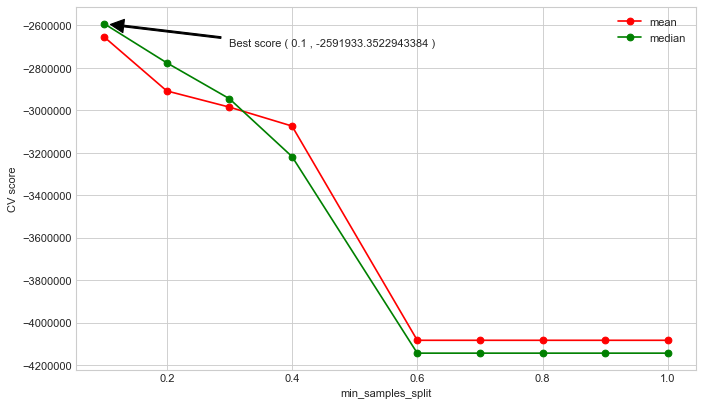

TREE: Score (MAE)-mean absolute error = 2714883.248 
Best parameter TREE (CV score = -2591933.352 ):
{'imputer__strategy': 'median', 'tree__min_samples_split': 0.1}
 
---------------------------------------------------- 
 
-----------------------  KNN ----------------------- 
 


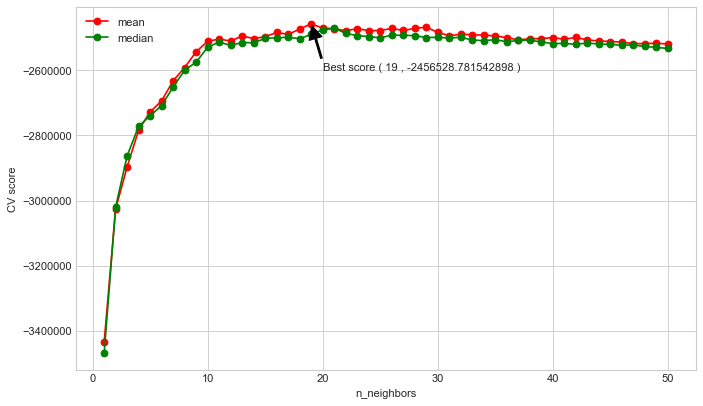

KNN: Score (MAE)-mean absolute error = 2339613.449 
Best parameter KNN (CV score = -2456528.782 ):
{'KNN__n_neighbors': 19, 'imputer__strategy': 'mean'}


In [7]:
#Selecting the closest blue points
X_train = train.iloc[:,:75].values
y_train = train.energy.values
X_test = test.iloc[:,:75].values
y_test = test.energy.values

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use('seaborn-whitegrid')
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

print(" ")
print("-----------------------  TREE ----------------------- ")
print(" ")

np.random.seed(0)
values = [0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9,1.0]
              
param_grid_tree = { 'imputer__strategy': ["mean", "median"],
                    'tree__min_samples_split': values 
                  }

pipe_tree = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('tree', DecisionTreeRegressor())])


pipeline_model_tree = GridSearchCV(pipe_tree, 
                                   param_grid=param_grid_tree, 
                                   cv=tr_val_partition,
                                   scoring='neg_mean_absolute_error')

pipeline_model_tree.fit(X=X_train, y=y_train)
y_test_pred_tree = pipeline_model_tree.predict(X_test)

params = pipeline_model_tree.cv_results_['params']
means = pipeline_model_tree.cv_results_['mean_test_score']
neig_mean = []
neig_median = []
score_mean = []
score_median = []

#Bucle to store data in arrays and represent them in graphs
for mean,  param in zip(means,  params):
    
    if(param['imputer__strategy']=='mean'):
        neig_mean.append(param['tree__min_samples_split'])
        score_mean.append(mean)
    else:
        neig_median.append(param['tree__min_samples_split'])
        score_median.append(mean)
    


ax = plt.subplot(111)

plt.plot(neig_mean, score_mean,'-ok', color='r', label="mean")  
line, = plt.plot(neig_median, score_median ,'-ok',color='g', label="median") 

text = 'Best score ( ' + str(pipeline_model_tree.best_params_['tree__min_samples_split']) + ' , ' + str(pipeline_model_tree.best_score_) +' )'
#Annotate the best value of the hyper-parameters 
plt.annotate(text, xy=(pipeline_model_tree.best_params_['tree__min_samples_split'], pipeline_model_tree.best_score_),
             xytext=(0.3, -2700000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            )


plt.xlabel("min_samples_split")
plt.ylabel("CV score")
plt.legend()
plt.show()
MAE_tree_1 = metrics.mean_absolute_error(y_test, y_test_pred_tree)
print("TREE: Score (MAE)-mean absolute error = %0.3f " % MAE_tree_1)
print("Best parameter TREE (CV score = %0.3f ):" % pipeline_model_tree.best_score_)
print(pipeline_model_tree.best_params_)


#KNN
print(" ")
print("---------------------------------------------------- ")    
print(" ")
print("-----------------------  KNN ----------------------- ")
print(" ")

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

values =list(range(1,51,1))
np.random.seed(0)           
pipe_KNN = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('KNN', KNeighborsRegressor())])

param_grid_KNN = {'imputer__strategy': ["mean","median"],
                  'KNN__n_neighbors': values
                 }
pipeline_model_KNN = GridSearchCV(pipe_KNN, 
                                  param_grid=param_grid_KNN, 
                                  cv= tr_val_partition,
                                  scoring='neg_mean_absolute_error'
                                 )

pipeline_model_KNN.fit(X=X_train, y=y_train)

y_test_pred_KNN= pipeline_model_KNN.predict(X_test)

params = pipeline_model_KNN.cv_results_['params']
means = pipeline_model_KNN.cv_results_['mean_test_score']
neig_mean = []
neig_median = []
score_mean = []
score_median = []

#Bucle to store data in arrays and represent them in graphs
for mean,  param in zip(means,  params):
    
    if(param['imputer__strategy']=='mean'):
        neig_mean.append(param['KNN__n_neighbors'])
        score_mean.append(mean)
    else:
        neig_median.append(param['KNN__n_neighbors'])
        score_median.append(mean)
    

ax = plt.subplot(111)


line, = plt.plot(neig_mean, score_mean, '-ok', color='r', label="mean")  
plt.plot(neig_median, score_median ,'-ok', color='g', label="median") 

text = 'Best score ( ' + str(pipeline_model_KNN.best_params_['KNN__n_neighbors']) + ' , ' + str(pipeline_model_KNN.best_score_) +' )'
#Annotate the best value of the hyper-parameters 

plt.annotate(text, xy=(pipeline_model_KNN.best_params_['KNN__n_neighbors'], pipeline_model_KNN.best_score_),
             xytext=(20, -2600000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            )
plt.xlabel("n_neighbors")
plt.ylabel("CV score")
plt.legend()
plt.show()


print("KNN: Score (MAE)-mean absolute error = %0.3f " % metrics.mean_absolute_error(y_test, y_test_pred_KNN))

print("Best parameter KNN (CV score = %0.3f ):" % pipeline_model_KNN.best_score_)
print(pipeline_model_KNN.best_params_)


# Conclusions

In the previous graphs it can be seen how the values of the CV function vary depending on the values of the hyper-parameters, for the two  inputation methods: 'mean' and 'mediate'. In both graphs these curves ('mean' and 'mediate') follow a similar trend as the hyper-parameter values vary. Of course, only 10 points appear in the Tree graph, given that 10 values are evaluated for the hyper-parameter 'tree__min_samples_split', however 50 points are used for KNN, given that 50 possible values of ‘n_neighbors’ are evaluated.

As you can see in the graphs the method with best result depends on whether Trees or KNN is used. In the case of Tree, the point of the graph that gives a lower value of the CV function is with the 'middle' method of imputation and using a 'tree__min_samples_split' of 0.1. However, for the KNN the best method is 'mean' using a 'n_neighbors’ of 19. 


# Second part

The aim of this part is to determine whether 1 blue point (the closest one to the solar plant) is enough to get good results, or if using more could improve results. In the previous exercise it was used only 1 blue point (75 variables), but the 16 blue points surrounding the solar plant (red point) are available. Now only 4 of the blue points are used, that is the first 75*4=300 variables.

In [8]:

X_train = train.iloc[:,:300].values
y_train = train.energy.values
X_test = test.iloc[:,:300].values
y_test = test.energy.values

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

np.random.seed(0)
              
pipe_tree = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy= 'median')),
        ('tree', DecisionTreeRegressor(min_samples_split= 0.1)
        )])

pipe_tree.fit(X=X_train, y=y_train)
y_test_pred_tree = pipe_tree.predict(X_test)

MAE_tree_2 = metrics.mean_absolute_error(y_test, y_test_pred_tree)
print("MAE with 75 features (closest blue point) = %0.3f " % MAE_tree_1 )
print("MAE with 300 features (4 closest blue points) = %0.3f " % MAE_tree_2 )

MAE with 75 features (closest blue point) = 2714883.248 
MAE with 300 features (4 closest blue points) = 2718026.295 


It can be seen how as the number of features increases the performance of the model decreases, obtaining a higher MAE in the evaluation.

In [9]:
X_train = train.iloc[:,:300].values
y_train = train.energy.values
X_test = test.iloc[:,:300].values
y_test = test.energy.values


np.random.seed(0)

param_grid = {
             'feature_selection__k': np.arange(X_train.shape[1])+1,
             }


pipe_tree = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('feature_selection', SelectKBest(f_regression)),
            ('tree', DecisionTreeRegressor(min_samples_split=0.1)
            )])

pipe_tree_model = GridSearchCV(pipe_tree, 
                        param_grid,
                        scoring='neg_mean_absolute_error',
                        cv=tr_val_partition)


pipe_tree_model.fit(X_train,y_train)


print(pipe_tree_model.best_params_, pipe_tree_model.best_score_)

y_test_pred_tree = pipe_tree_model.predict(X_test)
MAE_tree_3 = metrics.mean_absolute_error(y_test, y_test_pred_tree)

print("MAE with 75 features (closest blue point) = %0.3f " % MAE_tree_1 )
print("MAE with 300 features (4 closest blue points) = %0.3f " % MAE_tree_2 )
print("MAE with "+ str(pipe_tree_model.best_params_['feature_selection__k']) + " features = %0.3f " % MAE_tree_3 )

{'feature_selection__k': 5} -2524963.9738518856
MAE with 75 features (closest blue point) = 2714883.248 
MAE with 300 features (4 closest blue points) = 2718026.295 
MAE with 5 features = 2765112.526 


In this case feature selection was performed and it can be seen that the optimal number of features is 5. Reducing the number of features to such a low number has consecuences. The positive aspect is that it makes the model simpler and more interpretable and the negative aspect is that it makes the model less precise.

In [10]:
import warnings
warnings.filterwarnings("ignore")
X_train = train.iloc[:,:300].values
y_train = train.energy.values
X_test = test.iloc[:,:300].values
y_test = test.energy.values
MAEs = []
k=[]

#Bucle to obtain the evaluations of the different models according to the number of features used in the 'feature selection'
for i in range(1,300):
    
    np.random.seed(0)
    pipe_tree = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('feature_selection', SelectKBest(k=i)),
            ('tree', DecisionTreeRegressor(min_samples_split=0.1)
            )])
    pipe_tree.fit(X_train,y_train)
    y_test_pred_tree = pipe_tree.predict(X_test)
    k.append(i)
    MAEs.append(metrics.mean_absolute_error(y_test, y_test_pred_tree))
    


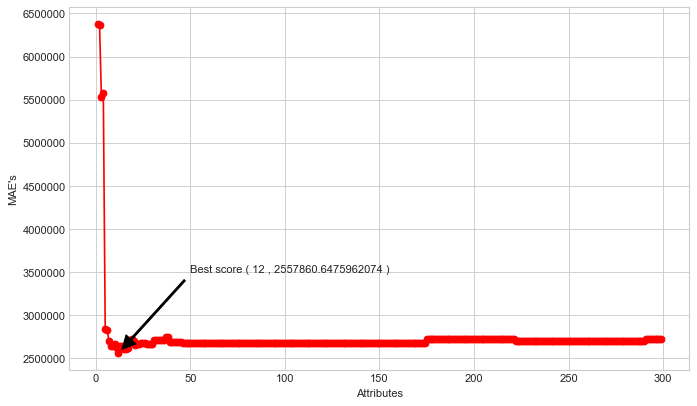

In [11]:
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(k, MAEs ,'-ok',color='r') 

i, = np.where(np.isclose(MAEs, min(MAEs)))


text = 'Best score ( ' + str(k[i[0]]) + ' , ' + str(min(MAEs)) +' )'

plt.annotate(text, xy=(k[i[0]], min(MAEs)),
             xytext=(50, 3500000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            )

plt.xlabel("Attributes")
plt.ylabel("MAE's")
plt.show()




In the previous graph it was represented how the number of attributes and features influences the MAE in the evaluation of each model in the feature selection. It can be seen that there is reduction of the error producing a minimum with 12 features. In this point the best evaluation of the model is obtained. It can also be verified that as the number of features increases, the MAE does not vary significantly.

In [12]:
X_train = train.iloc[:,:300].values
y_train = train.energy.values
X_test = test.iloc[:,:300].values
y_test = test.energy.values

np.random.seed(0)

pipe_tree = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy= 'median')),
        ('feature_selection', SelectKBest(k=12)),
        ('tree', DecisionTreeRegressor(min_samples_split= 0.1)
        )])

pipe_tree.fit(X=X_train, y=y_train)
y_test_pred_tree = pipe_tree.predict(X_test)

MAE_tree_4 = metrics.mean_absolute_error(y_test, y_test_pred_tree)

print("MAE with 75 features (closest blue point) = %0.3f " % MAE_tree_1 )
print("MAE with 300 features  ( 4 closest blue points) = %0.3f " % MAE_tree_2 )
print("MAE with 5 features = %0.3f " % MAE_tree_3 )
print("MAE with 12 features = %0.3f " % MAE_tree_4 )

MAE with 75 features (closest blue point) = 2714883.248 
MAE with 300 features  ( 4 closest blue points) = 2718026.295 
MAE with 5 features = 2765112.526 
MAE with 12 features = 2557860.648 


## Conclusion

The model with 12 features, is the one with which the best evaluation (lower MAE) is obtained, in addition the model will be more interpretable and simple due to the reduction of the number of features. So it is not necessary to have more than 75 features to obtain a better evaluation of the model, but better evaluations are obtained with a smaller number of features and a simpler and interpretable model is obtained through this feature reduction.

# Third part

In this final part Random Forest and Gradient Boosting with hyper-parameter tuning were performed on either 75 or 300 variables, depending on the results on the previous part.

In [25]:
#FOR LINUX USE:
#!pip3 install xgboost 
#For Windows in the anaconda terminal use:
#conda install -c anaconda py-xgboost


As it was seen before the best evaluation is obtained with 75 features so, for this part only 75 variables were used.

 
-----------------------  RANDOM FOREST ----------------------- 
 


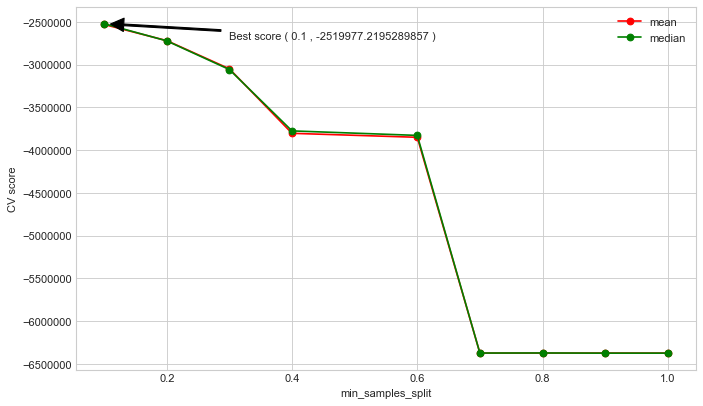

RANDOM FOREST: Score (MAE)-mean absolute error = 2654502.122 
Best parameter RANDOM FOREST (CV score = -2519977.220 ):
{'classifier__min_samples_split': 0.1, 'imputer__strategy': 'median'}


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X_train = train.iloc[:,:75].values
y_train = train.energy.values
X_test = test.iloc[:,:75].values
y_test = test.energy.values

plt.style.use('seaborn-whitegrid')
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

np.random.seed(0)
values = [0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9,1.0]

param_grid_random = {
                    'imputer__strategy': ["mean", "median"],
                    'classifier__min_samples_split': values
                  }
pipe_random = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('classifier', RandomForestRegressor())])


pipeline_model_random = GridSearchCV(pipe_random, 
                                   param_grid=param_grid_random, 
                                   cv=tr_val_partition, 
                                   scoring='neg_mean_absolute_error')

pipeline_model_random.fit(X=X_train, y=y_train)
y_test_pred_random = pipeline_model_random.predict(X_test)

params = pipeline_model_random.cv_results_['params']
means = pipeline_model_random.cv_results_['mean_test_score']
neig_mean = []
neig_median = []
score_mean = []
score_median = []

#Bucle to store data in arrays and represent them in graphs
for mean,  param in zip(means,  params):
    
    if(param['imputer__strategy']=='mean'):
        neig_mean.append(param['classifier__min_samples_split'])
        score_mean.append(mean)
    else:
        neig_median.append(param['classifier__min_samples_split'])
        score_median.append(mean)
        
print(" ")
print("-----------------------  RANDOM FOREST ----------------------- ")
print(" ")

ax = plt.subplot(111)

plt.plot(neig_mean, score_mean,'-ok', color='r', label="mean")  
line, = plt.plot(neig_median, score_median ,'-ok',color='g', label="median") 

text = 'Best score ( ' + str(pipeline_model_random.best_params_['classifier__min_samples_split']) + ' , ' + str(pipeline_model_random.best_score_) +' )'
#Annotate the best value of the hyper-parameters 
plt.annotate(text, xy=(pipeline_model_random.best_params_['classifier__min_samples_split'], pipeline_model_random.best_score_),
             xytext=(0.3, -2700000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            )


plt.xlabel("min_samples_split")
plt.ylabel("CV score")
plt.legend()
plt.show()
MAE_tree_1 = metrics.mean_absolute_error(y_test, y_test_pred_random)
print("RANDOM FOREST: Score (MAE)-mean absolute error = %0.3f " % MAE_tree_1)
print("Best parameter RANDOM FOREST (CV score = %0.3f ):" % pipeline_model_random.best_score_)
print(pipeline_model_random.best_params_)

In this case it can be seen that the curves of 'mean' and 'median' follows a similar trend as the individual decision tree with the same 10 values that were evaluated for the hyper-parameter 'min_samples_split'. Same as in the case of Tree, the point of the graph that gives a lower value of the CV function is with the 'median' method of imputation and using a 'min_samples_split' of 0.1. 

In this case it was obtained a better evaluation than the Tree with a lower MAE. Random Forest scores a 2654502.122  MAE and Tree scored 2714883.248. 

 
-----------------------  XTREME GRADIENT BOOSTING ----------------------- 
 


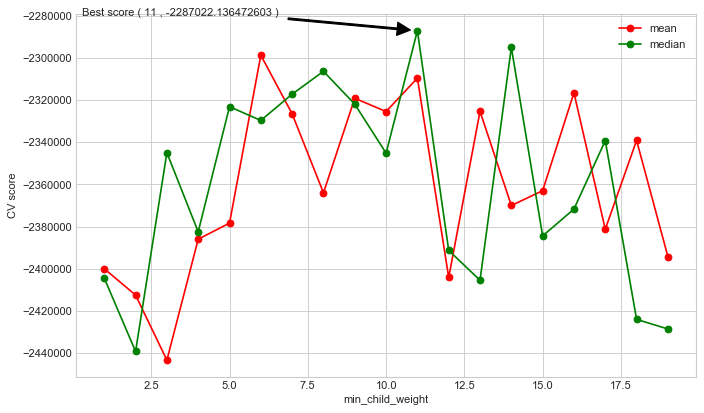

XTREME GRADIENT BOOSTING: Score (MAE)-mean absolute error = 2254213.589 
Best parameter XTREME GRADIENT BOOSTING (CV score = -2287022.136 ):
{'classifier__min_child_weight': 11, 'imputer__strategy': 'median'}


In [25]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

pipe_xgboost = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier', XGBRegressor(objective ='reg:squarederror'))])

values = [0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9,1.0]

param_grid_xgboost = {'imputer__strategy': ["mean","median"],
                      'classifier__min_child_weight':range(1,20,1)
                      }

pipeline_model_xgboost = GridSearchCV(pipe_xgboost, 
                                   param_grid=param_grid_xgboost, 
                                   cv=tr_val_partition, 
                                   scoring='neg_mean_absolute_error')

pipeline_model_xgboost.fit(X=X_train, y=y_train)
y_test_pred_xgboost = pipeline_model_xgboost.predict(X_test)

params = pipeline_model_xgboost.cv_results_['params']
means = pipeline_model_xgboost.cv_results_['mean_test_score']
neig_mean = []
neig_median = []
score_mean = []
score_median = []

#Bucle to store data in arrays and represent them in graphs
for mean,  param in zip(means,  params):
    
    if(param['imputer__strategy']=='mean'):
        neig_mean.append(param['classifier__min_child_weight'])
        score_mean.append(mean)
    else:
        neig_median.append(param['classifier__min_child_weight'])
        score_median.append(mean)
        
print(" ")
print("-----------------------  XTREME GRADIENT BOOSTING ----------------------- ")
print(" ")


ax = plt.subplot(111)

plt.plot(neig_mean, score_mean,'-ok', color='r', label="mean")  
line, = plt.plot(neig_median, score_median ,'-ok',color='g', label="median") 

text = 'Best score ( ' + str(pipeline_model_xgboost.best_params_['classifier__min_child_weight']) + ' , ' + str(pipeline_model_xgboost.best_score_) +' )'
#Annotate the best value of the hyper-parameters 
plt.annotate(text, xy=(pipeline_model_xgboost.best_params_['classifier__min_child_weight'], pipeline_model_xgboost.best_score_),
             xytext=(0.3, -2280000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            )


plt.xlabel("min_child_weight")
plt.ylabel("CV score")
plt.legend()
plt.show()
MAE_tree_1 = metrics.mean_absolute_error(y_test, y_test_pred_xgboost)
print("XTREME GRADIENT BOOSTING: Score (MAE)-mean absolute error = %0.3f " % MAE_tree_1)
print("Best parameter XTREME GRADIENT BOOSTING (CV score = %0.3f ):" % pipeline_model_xgboost.best_score_)
print(pipeline_model_xgboost.best_params_)

As it can be seen in this case, with Xtreme Gradient Boosting the 'mean' and 'median' follows a continous linear trend with an inapreciate changes during the evaluation for the hyper-parameter 'min_child_weight' and very close together. That is because XGBoost deals with missing values by deciding for each sample which is the best way to impute them. 

Best value is obtanied, with the 'mean' method of imputation and using a 'min_child_weight' of 0.1. In the others case the best method was allways 'median'.

Here  a better evaluation than the Tree was obtained. Xtreme Gradient Boosting scores a 2254213.589 MAE and Tree scored 2714883.248. 

 
-----------------------  XTREME GRADIENT BOOSTING ----------------------- 
 


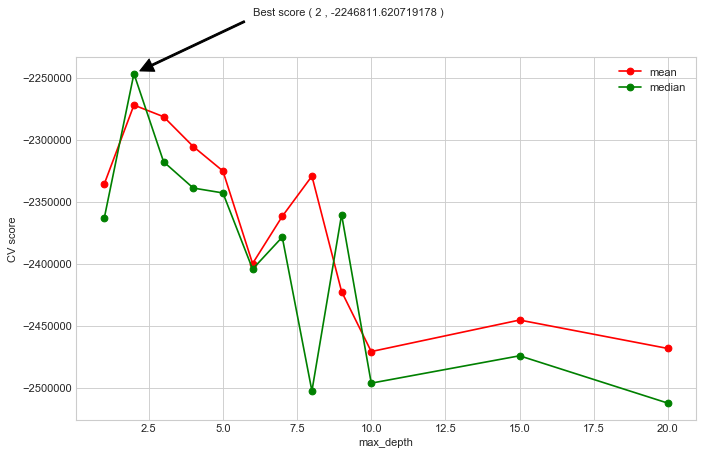

XTREME GRADIENT BOOSTING: Score (MAE)-mean absolute error = 2184104.485 
Best parameter XTREME GRADIENT BOOSTING (CV score = -2246811.621 ):
{'classifier__max_depth': 2, 'imputer__strategy': 'median'}


In [26]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

pipe_xgboost = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier', XGBRegressor(objective ='reg:squarederror'))])

values = [1,2,3,4,5,6,7,8,9,10,15,20]

param_grid_xgboost = {'imputer__strategy': ["mean","median"],
                      'classifier__max_depth': values}

pipeline_model_xgboost = GridSearchCV(pipe_xgboost, 
                                   param_grid=param_grid_xgboost, 
                                   cv=tr_val_partition, 
                                   scoring='neg_mean_absolute_error')

pipeline_model_xgboost.fit(X=X_train, y=y_train)
y_test_pred_xgboost = pipeline_model_xgboost.predict(X_test)

params = pipeline_model_xgboost.cv_results_['params']
means = pipeline_model_xgboost.cv_results_['mean_test_score']
neig_mean = []
neig_median = []
score_mean = []
score_median = []

#Bucle to store data in arrays and represent them in graphs
for mean,  param in zip(means,  params):
    
    if(param['imputer__strategy']=='mean'):
        neig_mean.append(param['classifier__max_depth'])
        score_mean.append(mean)
    else:
        neig_median.append(param['classifier__max_depth'])
        score_median.append(mean)
        
print(" ")
print("-----------------------  XTREME GRADIENT BOOSTING ----------------------- ")
print(" ")


ax = plt.subplot(111)

plt.plot(neig_mean, score_mean,'-ok', color='r', label="mean")  
line, = plt.plot(neig_median, score_median ,'-ok',color='g', label="median") 

text = 'Best score ( ' + str(pipeline_model_xgboost.best_params_['classifier__max_depth']) + ' , ' + str(pipeline_model_xgboost.best_score_) +' )'
#Annotate the best value of the hyper-parameters 
plt.annotate(text, xy=(pipeline_model_xgboost.best_params_['classifier__max_depth'], pipeline_model_xgboost.best_score_),
             xytext=(6, -2200000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            )


plt.xlabel("max_depth")
plt.ylabel("CV score")
plt.legend()
plt.show()
MAE_tree_1 = metrics.mean_absolute_error(y_test, y_test_pred_xgboost)
print("XTREME GRADIENT BOOSTING: Score (MAE)-mean absolute error = %0.3f " % MAE_tree_1)
print("Best parameter XTREME GRADIENT BOOSTING (CV score = %0.3f ):" % pipeline_model_xgboost.best_score_)
print(pipeline_model_xgboost.best_params_)

Here the hyper-parameter 'max_depth' was evaluated, with the 'median' method of imputation and finding an optimal value with a 'max_depth' of 2. 

With this parameter Xtreme Gradient Boosting scores a 2184104.485 MAE and Tree scored 2714883.248. 

# Conclusions

As it can be seen in both cases the 2 methods improve the results, scoring a lower MAE than the individual decision tree. That is because the ensemble techniques, like xgboost, are algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging) and bias (boosting).

The reason of this is because when it was tried to predict the response using any machine learning techniques like Tree or KNN, the main causes of difference in actual and predicted values are noise, variance, and bias. This ensemble techniques reduce these factors (except noise).

Bagging is a ensemble technique for reducing the variance and is used by Random Forest. Works by building many independent predictors/models/learners and combine them using some model averaging techniques like eighted average or normal average. This technique takes many uncorrelated learners to make a final model, it reduces error by reducing variance. 

Boosting is a ensemble technique for reduce the variance and the bias and is used by Gradient Boosting. In this technique the predictors are made sequentially and in this way the predictors learn from the mistakes of the previous predictors. The predictors can be chosen from a range of models like decision trees, regressors, classifiers etc. Because new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. 